<a href="https://colab.research.google.com/github/MuhammadSafeer786/My-PyTorch-Journey/blob/main/Chapter_02_PyTorch_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare Data

In [2]:
import torch
from torch import nn # all building blockes for neural network
import matplotlib.pyplot as plt
torch.__version__

'2.5.1+cu121'

Trying to create our own dataset by **Linear Regression** Formula

In [3]:
# create known parameters
weight = 0.7
bias = 0.3

# create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

In [4]:
train_split = int(0.8 * len(X)) # no. of samples for training
train_split

40

In [5]:
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [6]:
def plot_predictions(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    predictions=None):
  plt.figure(figsize=(10, 7))

  # plot training data in green
  plt.scatter(train_data, train_labels, c="g", s=4, label="Training data")

  # plot test data in red
  plt.scatter(test_data, test_labels, c="b", s=20, label="Testing data")

  if predictions is not None:
    # plot predictions in blue
    plt.scatter(test_data, predictions, c="r", s=20, label="Predictions")

  # show legend
  plt.legend(prop={"size": 20})

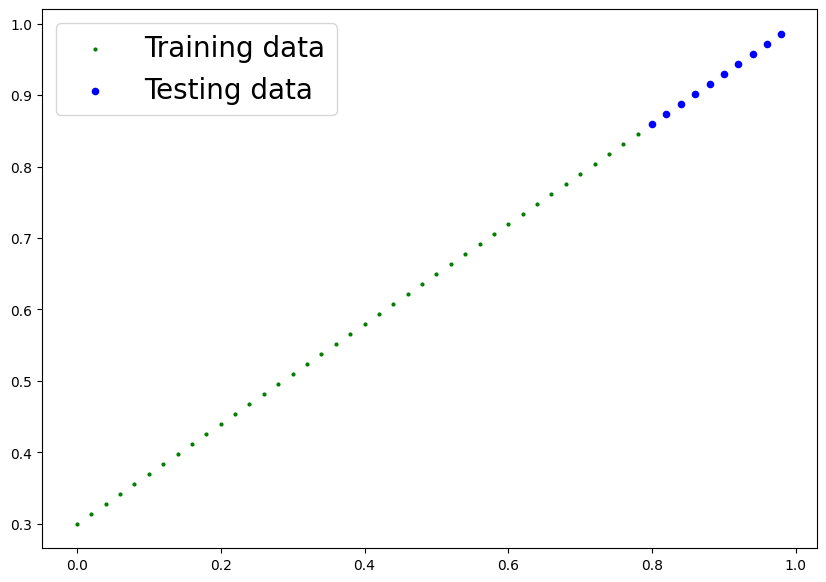

In [7]:
plot_predictions()

# Building Model
Must watch these (for me only):

Gradient descent - https://youtu.be/IHZwWFHWa-w

Backpropagation - https://youtu.be/Ilg3gGewQ5U

**Search about super().__init__()**

In [8]:
class CustomLinearRegression(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    # forward pass method in linear regression method
  def forward(self, x: torch.Tensor) -> torch.Tensor: # type hint / annotation, means dtype of x should be torch.Tensor and -> means return type should be as specified after this symbol
    return self.weights * x + self.bias

## PyTorch cheat sheet
https://pytorch.org/tutorials/beginner/ptcheat.html

# Check Model contents

In [9]:
torch.manual_seed(42)
model = CustomLinearRegression()

list(model.parameters()) # model.parameters() is a generator so i converted it to list for visualizing

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
model.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

# Making Predictions without Training
Turning of gradient tracking and only forward pass

For reading differences between torch.no_grad() and torch.inference_mode() search these on twitter.

In [11]:
with torch.inference_mode(): # torch.no_grad() can also be used. these mode just disable gradient tracking, for testing, faster calculation
  y_preds = model(X_test) # can only use this code for getting predictions but would also track gradient.

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

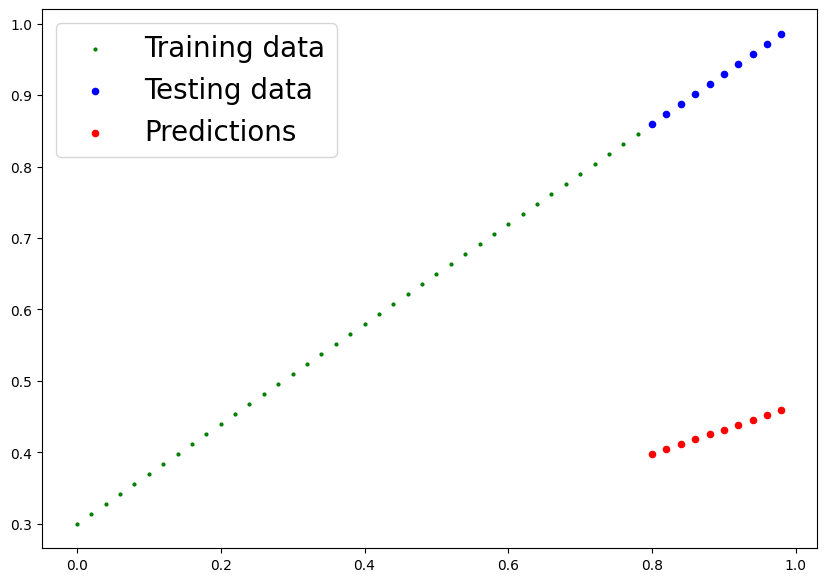

In [12]:
plot_predictions(predictions=y_preds)

# Training Model

* Loss Function i.e. mean squared error
* Optimizer i.e. gradient descent

In [13]:
loss_func = nn.L1Loss() # mean squared error
optimizer = torch.optim.SGD(params = model.parameters(), lr=0.01) # stochastic gradient descent

In [14]:
from IPython.display import clear_output

def plot_predictions_dynamic(train_data, train_labels, predictions=None):

    clear_output(wait=True)  # Clear previous output
    plt.figure(figsize=(10, 7))

    # Plot training data in green
    plt.scatter(train_data, train_labels, c="g", s=4, label="Training data")

    if predictions is not None:
        # Plot predictions in red
        plt.plot(train_data, predictions, c="r", label="Predictions")

    # Show legend
    plt.legend(prop={"size": 10})
    plt.show()


**Why turn off grads after every iteration in the following loop?**

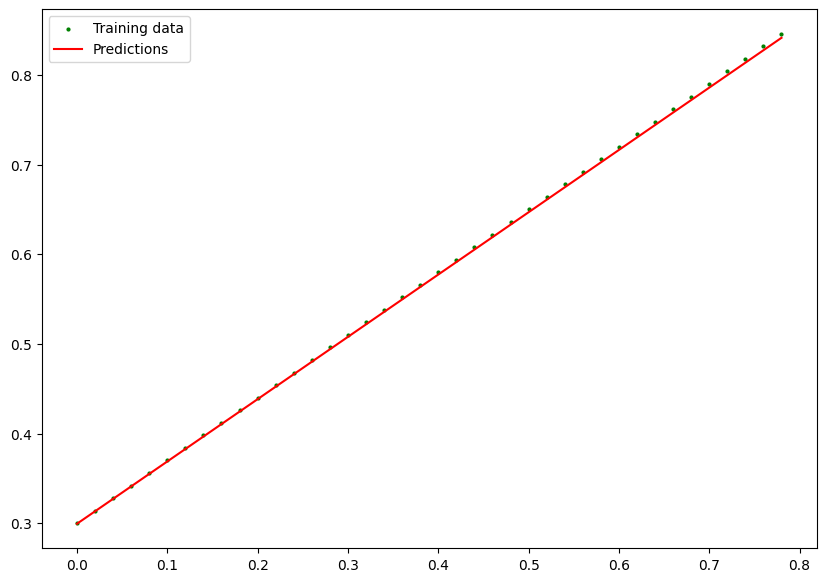

In [24]:
torch.manual_seed(42)
epochs = 500

# trackers goes here i.e. lists to store losses and epochs and afterwards create plots for losses

for epoch in range(epochs):
    model.train()  # Enable training mode (enables gradient tracking)

    # Forward pass
    y_preds = model(X_train)

    # Plot predictions dynamically
    plot_predictions_dynamic(
        train_data=X_train.numpy(),
        train_labels=y_train.numpy(),
        predictions=y_preds.detach().numpy()
    )

    # Calculate loss
    loss = loss_func(y_preds, y_train)

    # Zero gradients
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Update parameters
    optimizer.step()

    model.eval() # optional, actually turns off many settings i.e batchnorm or drop out etc.
    # testing code goes here for to compare model metrics one each epoch. optional


In [16]:
model.state_dict() # got as close as the model could to the orignal weights and biases. it means almost 99.99% accuracy on trian dataset

OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])

In [17]:
torch.manual_seed(42)
with torch.inference_mode():
  y_preds = model(X_test)
  test_loss = loss_func(y_preds, y_test)

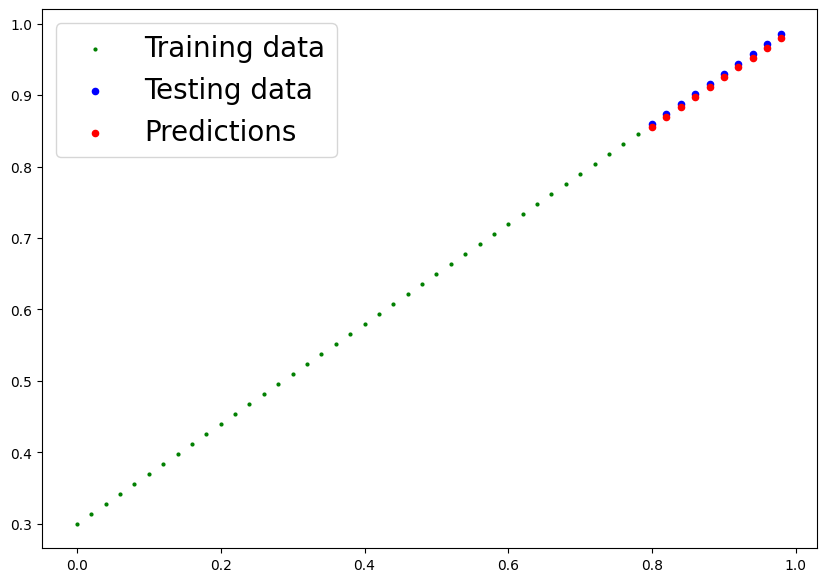

In [18]:
plot_predictions(predictions=y_preds)

In [19]:
print(f"Training loss: {loss} | Testing loss: {test_loss}")

Training loss: 0.008932482451200485 | Testing loss: 0.005023092031478882


# Saving & Loading Model

In [20]:
# saving just the state_dict, you can save whole object
from pathlib import Path


mdl_path = Path("CustomLinearRegression.pth")
torch.save(obj=model.state_dict(), f=mdl_path)

In [21]:
load_mdl = CustomLinearRegression()
load_mdl.load_state_dict(torch.load(f=mdl_path))

<ipython-input-21-d6f3355fe94b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_mdl.load_state_dict(torch.load(f=mdl_path))


<All keys matched successfully>

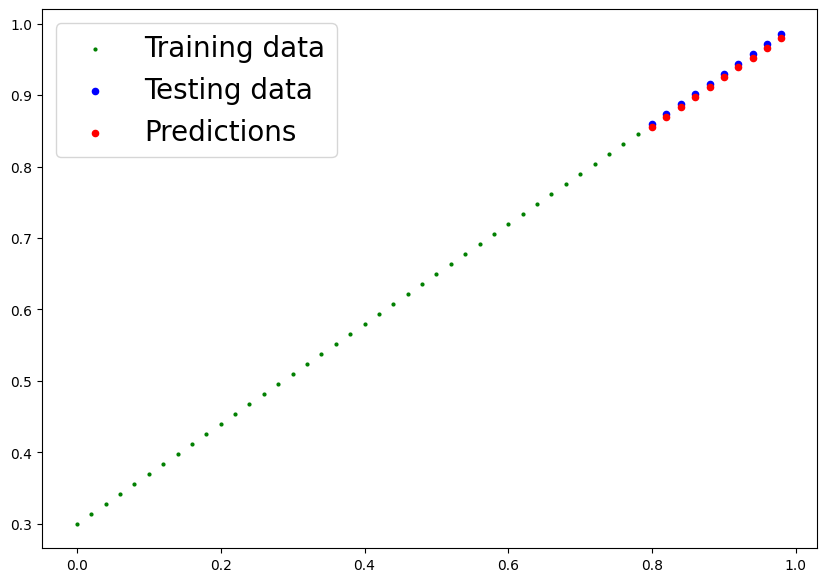

In [22]:
## Make some predictions
load_mdl.eval()
with torch.inference_mode():
  y_preds = load_mdl(X_test)

plot_predictions(predictions=y_preds)